# 3D Pluri-Gaussian simulation

>**Note:** This notebook is inspired from the notebook [ex_pgs.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_pgs.ipynb) by Julien Straubhaar.

In this notebook we demonstrate a 3D application of pluri-Gaussian simulation (PGS).

Some details are omited for the sake of brievity because already explained in the example about 2D PGS.

First, import the required modules

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
# import package 'geone'
import geone as gn

import pyvista as pv
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

Then, define some categories and colours.

In [2]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Colours for the plots
categCol = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']

Define the simulation grid

In [3]:
nx, ny, nz = 120, 110, 55   # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

Define the covariance models for the two latent fields and the "flag" function.

In [4]:
# Covariance model T1
r_T1 = 1.0*np.array([15.0, 15.0, 15.0])
w_T1 = 1.0
nu_T1 = 1.5
cov_model_T1 = gn.covModel.CovModel3D(elem=[
    ('matern', {'w':w_T1, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T1, r) for r in r_T1]), 'nu':nu_T1}),
    ('nugget', {'w':0.01*w_T1})
    ], alpha=0.0, beta=0.0, gamma=0.0, name='cov_model_T1')

# Covariance model T2
r_T2 = 1.0*np.array([30.0, 10.0, 10.0])
w_T2 = 1.0
nu_T2 = 1.5
cov_model_T2 = gn.covModel.CovModel3D(elem=[
    ('matern', {'w':w_T2, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T2, r) for r in r_T2]), 'nu':nu_T2}),
    ], alpha=-45.0, beta=0.0, gamma=0.0, name='cov_model_T2')

# Mean of T1, T2
mean_T1 = 0.0
mean_T2 = 0.0

# "flag" function definition
def flag_value(x, y):
    v0, v1, v2, v3 = categVal
    x1 = x < -0.5
    y1 = y < -1.
    y2 = y < 1.
    return v0 * x1 + (1-x1) * (v1 * y1 + (1-y1) * (v2*y2 + v3*(1-y2)))

/home/alex/.virtualenvs/gmg/lib/python3.10/site-packages/geone/covModel.py:209: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


Define some conditioning data (3D now)

In [5]:
x = np.array([[17.25, 15.25, 15.5],
              [47.25, 14.25, 23.5],
              [31.25, 32.25, 10.5],
              [18.25, 49.25, 20.5],
              [46.25, 48.25, 40.5]])
v = np.array([1, 1, 2, 4, 4])
# Define some colours to plot conditioning data
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v]

Perform 3D PGS

In [6]:
# Number of realizations and seed
nreal = 3
seed_sim = 13454
np.random.seed(seed_sim)

# Simulation
Z, T1, T2, n_cond_ok = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz),
    x=x, v=v,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2},# 'rangeFactorForExtensionMin':2},
    # algo_T1='classic', params_T1={'mean':mean_T1, 'nneighborMax':24}, # alternative algo for T1
    # algo_T2='classic', params_T1={'mean':mean_T2, 'nneighborMax':24}, # alternative algo for T2
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=True,
    verbose=4,
)

print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T1 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T1.shape[0], val=T1)
im_T2 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T2.shape[0], val=T2)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

PLURIGAUSSIANSIM: simulation 1 of 3...
PLURIGAUSSIANSIM: simulation 2 of 3...
PLURIGAUSSIANSIM: simulation 3 of 3...
Number of realizations generated: 3
Conditioning data honoured ? True


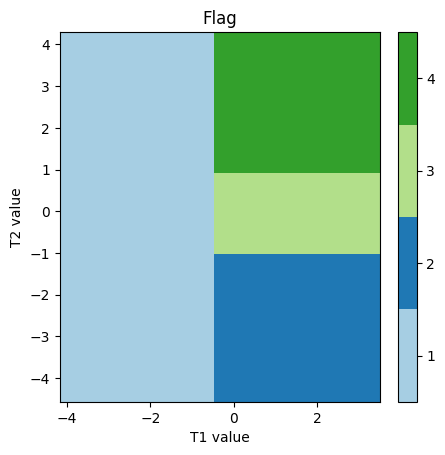

In [7]:
# Plot flag function 
# ------------
ireal = 0 # Select the realization to plot

# Fill image for flag
# ------------------
fnx, fny, fnz = 50, 50, 1
fox, foy, foz = im_T1.val[ireal].min(), im_T2.val[ireal].min(), 0.0
fsx, fsy, fsz = (im_T1.val[ireal].max() - fox)/fnx, (im_T2.val[ireal].max() - foy)/fny, 1.0
fx = fox + (np.arange(fnx)+0.5)*fsx 
fy = foy + (np.arange(fny)+0.5)*fsy 
yy, xx = np.meshgrid (fy, fx, indexing='ij')
fv = flag_value(xx, yy)
im_flag = gn.img.Img(nx=fnx, ny=fny, nz=fnz, sx=fsx, sy=fsy, sz=fsz, ox=fox, oy=foy, oz=foz, nv=1, val=fv)

# Plot flag
# ---------
plt.figure()
gn.imgplot.drawImage2D(im_flag, categ=True, categVal=categVal, categCol=categCol)
plt.xlabel('T1 value')
plt.ylabel('T2 value')
plt.title(f'Flag')
plt.show()

## Save a VTK file

The results of the simulations can be saved into an external file for further processing (for example, to the define the spatial variability of the hydraulical properties of an aquifer). `geone` allows to save the output on different formats, but one format that can be used to easily visualize the results, in particular when 3D, is Paraview ([www.paraview.org](https://www.paraview.org/))

For example, we can save the *Image* object that contains the results of the simulation, that is the variable $Z$.

In [8]:
gn.img.writeImageVtk(im_Z, "PGS_Z.vtk")

And also one of the latent fieds, for example $T_1$

In [10]:
gn.img.writeImageVtk(im_Z, "PGS_T1.vtk")

Note that `geone` also offers the possibility to visualize the results directly in Python, thorough the library `pyvista`, also in interactive mode. Please see the documentation and some example notebooks (like [ex_a_01_image_and_pointset.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_a_01_image_and_pointset.ipynb)) for more details.